# projX demonstation notebook
<pre> 
Guillermo Perez-Hernandez  guille.perez@fu-berlin.de 
</pre>
   
In this notebook we will be using the 1 millisecond trajectory of Bovine Pancreatic Trypsin Inhibitor (BPTI) generated by DE Shaw Research on the Anton Supercomputer and kindly made available by their lab. The original work is 
 * Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y, Wriggers W: Atomic-level characterization of the structural dynamics of proteins. Science 330:341-346 (2010).  doi: 10.1126/science.1187409.
 
The trajectory has been duplicated and shortened to provide a mock-trajectory set and be able to deal with lists of trajectories of different lenghts:
 * `data/c-alpha_centered.stride.100.xtc`
 * `data/c-alpha_centered.stride.100.reversed.xtc`
 * `data/c-alpha_centered.stride.100.halved.xtc`

## Input types and typical usecase
The typical usecase is having molecular dynamics (MD) simulation data in form of trajectory files with extensions like `.xtc, .dcd` etc and the associated molecular topology as a `.pdb` or `.gro` file. 

These files are the most general starting point for any analysis dealing with MD, and ```projX```'s API has been designed to be able to function without further input:

In [1]:
top = 'data/bpti-c-alpha_centered.pdb'
MD_trajfiles = ['data/c-alpha_centered.stride.100.xtc',
                'data/c-alpha_centered.stride.100.reversed.xtc',
                'data/c-alpha_centered.stride.100.halved.xtc'
               ]
import projX
%matplotlib notebook
import pyemma
import numpy as np

**However**, `projX` uses heavily the awesome `mdtraj` (http://www.mdtraj.org) module for dealing with molecular structures, and so most of its functions accept also `Trajectory`-type objects (native to `mdtraj`) as alternative inputs. 

In [2]:
# Create a memory representation of the trajectory
MD_list = [projX.generate._md.load(itraj, top=top) for itraj in MD_trajfiles]

The same idea applies to the input of projected trajectories: `projX` can take the filenames as inputs (`.npy`, `.dat`, `.txt` etc) or deal directly with `numpy.ndarray` objects. 

The following cell either reads or generates projected trajectory files for this demonstration. In a real usecase this step (done here using TICA) might not be needed, given that the user might have generated the projected trajectory elsewhere:

In [3]:
# Perform TICA or read from file directly if already .npy-files already exist
Y_filenames = [ff.replace('.xtc','.Y.npy') for ff in MD_trajfiles]
try:        
    Y = [np.load(ff) for ff in Y_filenames]
except:
    import pyemma
    feat = pyemma.coordinates.featurizer(top)
    pairs = feat.pairs(range(feat.topology.n_atoms)[::2])
    feat.add_distances(pairs)
    src  = pyemma.coordinates.source(MD_trajfiles, features=feat)
    tica = pyemma.coordinates.tica(src, lag=100, dim=3)
    Y = tica.get_output()    
    
    [np.save(ff, iY) for ff, iY in zip(Y_filenames, Y)]

** These alternative, "from-memory" input modes avoid forcing the user to read from file everytime an API function is called, saving `I/O` overhead**

## Visualize a FES and the molecular structures behind it
Execute the following cell and click either on the FES or on the slidebar

In [4]:
"""
ax, fig, iwd, data_sample, geom = projX.visualize.FES(
                                                      MD_list, 
                                                      #MD_trajfiles, 
                                                      top, 
                                                      Y_filenames, 
                                                      #Y, 
                                                      nbins=50, 
                                                      xlabel='TICA_0', ylabel='TICA_1'
                                          )
iwd
"""

"\nax, fig, iwd, data_sample, geom = projX.visualize.FES(\n                                                      MD_list, \n                                                      #MD_trajfiles, \n                                                      top, \n                                                      Y_filenames, \n                                                      #Y, \n                                                      nbins=50, \n                                                      xlabel='TICA_0', ylabel='TICA_1'\n                                          )\niwd\n"

## Visualize trajectories, FES and molecular structures
The user can sample structures as they occurr in sequence in the actual trajectory. When reading from file, this can be more time consuming. Objects in memory can be strided down to fewer frames to accellerate the process.

<IPython.core.display.Javascript object>


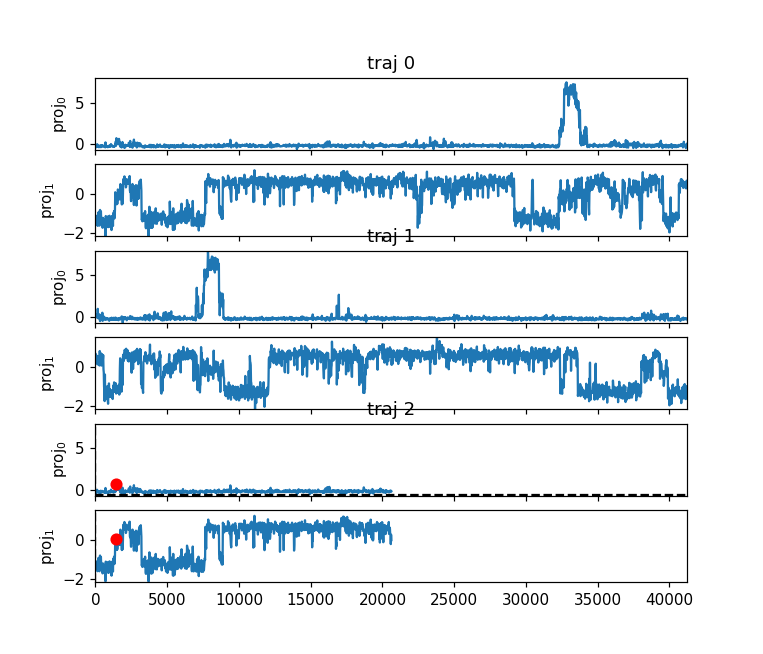

<IPython.core.display.Javascript object>


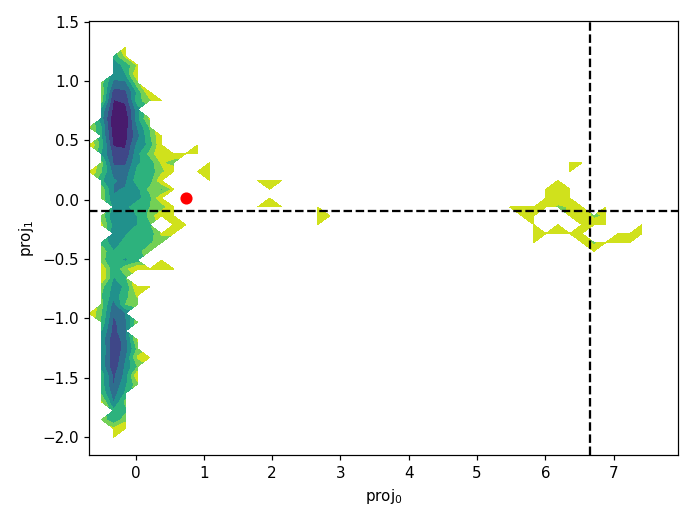

/home/mi/gph82/SOURCE_gph82/python/projection_explorer/projX/visualize.py:223: RuntimeWarning: divide by zero encountered in log
  _plt.contourf(-_np.log(h).T, extent=irange)
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [9]:
__, myfig, iwd, __ = projX.visualize.traj(MD_list, 
                                          #MD_trajfiles, 
                                          top, 
                                          Y, 
                                          #Y_filenames,
                                          active_traj=2,
                                          plot_FES = True,
                                          max_frames=2000,                                           
                                          #proj_idxs=[1,2], 
                                          #sharey_traj=False,
                          )
myfig.tight_layout()
iwd


# Intermediate steps: using projX to generate a regspace sample of the data

In [6]:
data_sample, geoms = projX.generate.sample(MD_list, 
                                      #MD_trajfiles, 
                                           top, Y, 
                                      n_points=200
                                      #keep_all_samples=True,                                      
                                      #n_geom_samples=200,
                                      #verbose=True
                                    )
data_sample.shape, geoms

03-03-17 12:03:25 pyemma.coordinates.clustering.regspace.RegularSpaceClustering[0] WARNING  Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
03-03-17 12:03:25 pyemma.coordinates.clustering.regspace.RegularSpaceClustering[0] INFO     Presumably finished estimation. Message: Used data for centers: 33.94%


/home/mi/gph82/programs/PyEmma/pyemma/coordinates/clustering/regspace.py:151: UserWarning: Maximum number of cluster centers reached. Consider increasing max_centers or choose a larger minimum distance, dmin.
  warnings.warn(msg)
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


((190, 2),
 <mdtraj.Trajectory with 190 frames, 58 atoms, 58 residues, and unitcells at 0x7f6f3475bf28>)

## Link the PDF plot with the sampled structures and visually explore the FES 
Click either on the plot or on the widget slidebar: they're connected! 

In [7]:
# Replot the FES
from matplotlib import pylab as plt
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y)[:,:2], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)
# Create the linked widget
linked_wdg = projX.visualize.sample(data_sample, 
                              geoms.superpose(geoms[0]),                             
                              plt.gca(), 
                              clear_lines=True,
                              #plot_path=True
                            )
plt.plot(data_sample[:,0], data_sample[:,1],' ok', zorder=0)
# Show it
linked_wdg

<IPython.core.display.Javascript object>

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


# Paths samples along the different projections/axis

In [8]:
paths_dict, idata = projX.generate.projection_paths(MD_list, 
                                                    #MD_trajfiles, 
                                                    top, 
                                                    ['data/Y.0.npy', 'data/Y.1.npy'],
                                                    #Y, # You can also directly give the data here
                                                    n_projs=2,
                                                    proj_dim = 3, 
                                                    verbose=False, 
                                        )

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


KeyboardInterrupt: 

## Link the PDF plot with the sampled paths/structures and visually explore the coordinates (separately). 
Click either on the plot or on the widget slidebar: they're connected! You can change the type of path between min_rmsd or min_disp and you can also change the coordinate sampled (0 or 1)


In [ ]:
# Choose the coordinate and the tyep of path
coord = 0
path_type = 'min_rmsd'
#path_type = 'min_disp'
igeom = paths_dict[coord][path_type]["geom"]
ipath = paths_dict[coord][path_type]["proj"]

In [ ]:
plt.figure(figsize=(7,7))
h, (x,y) = np.histogramdd(np.vstack(Y)[:,:2], bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

linked_wdg = projX.visualize.sample(ipath[:,:2], 
                              igeom.superpose(igeom[0]),                             
                              plt.gca(), 
                              clear_lines=True,
                              plot_path=True
                            )
linked_wdg

# Intereaction with ```PyEMMA```
`projX` is using many methods of the `coordinates` submodule of `PyEMMA`, and thus it also understands some of `PyEMMA`'s classes as input (for the moment, only clustering).

## Use a clustering object as input 
If the dataset has already been clustered, and it is **that** clustering that the user wants to explore, `projX.generate.sample` can take this clustering object as an input instead of the 
the projected trajectories:

In [ ]:
# Do "some" clustering
clkmeans = pyemma.coordinates.cluster_kmeans([iY[:,:2] for iY in Y], 5)

In [ ]:
data_sample, geoms = projX.generate.sample(MD_trajfiles, top, clkmeans, 
                                     n_geom_samples=50, 
                                     #keep_all_samples=True # read the doc for this argument
                                    )

In [ ]:
# Plot clusters
plt.figure(figsize=(7,7))
plt.plot(clkmeans.clustercenters[:,0], clkmeans.clustercenters[:,1],' ok')
# FES as background is optional (change the bool to False)
if True:
    plt.contourf(x[:-1], y[:-1], -np.log(h.T), alpha=.50)

# Link the clusters positions with the molecular structures
iwdg = projX.visualize.sample(data_sample, 
                              geoms.superpose(geoms[0]),                             
                              plt.gca(), 
                              clear_lines=False,
                              #plot_path=True
                            )
iwdg

# Visual Representations for MSMs
Visually inspect the network behind an MSM

In [ ]:
MSM = pyemma.msm.estimate_markov_model(clkmeans.dtrajs, 20)

In [ ]:
plt.figure(figsize=(7,7))

ax, pos  = pyemma.plots.plot_markov_model(MSM.P, 
                                          minflux=5e-4, 
                                          arrow_labels=None,
                                          ax=plt.gca(), 
                                          arrow_curvature = 2, show_frame=True,
                                          pos=clkmeans.clustercenters)
# Add a background if wanted
h, (x, y) = np.histogramdd(np.vstack(Y)[:,:2], weights=np.hstack(MSM.trajectory_weights()),  bins=50)
plt.contourf(x[:-1], y[:-1], -np.log(h.T), cmap="jet", alpha=.5, zorder=0)
plt.xlim(x[[0,-1]])
plt.xticks(np.unique(x.round()))
plt.yticks(np.unique(y.round()))

plt.ylim(y[[0,-1]])

iwd = projX.visualize.sample(pos, geoms, plt.gca())
iwd

# TPT Reactive Pathway Representation

In [ ]:
# Do an MSM with a realistic number of clustercenters
cl_many = pyemma.coordinates.cluster_regspace([iY[:,:2] for iY in Y], dmin=.25)
M = pyemma.msm.estimate_markov_model(cl_many.dtrajs, 20)
cl_many.n_clusters

In [ ]:
# Use this object to sample geometries
pos, geom = projX.generate.sample(MD_trajfiles, top, cl_many)

In [ ]:
# Find the most representative microstate of each 
# and least populated macrostate
M.pcca(3)
dens_max_i = [distro.argmax() for distro in M.metastable_distributions]
A = np.argmax([M.stationary_distribution[iset].sum() for iset in M.metastable_sets])
B = np.argmin([M.stationary_distribution[iset].sum() for iset in M.metastable_sets])
print(cl_many.clustercenters[dens_max_i[A]],
      cl_many.clustercenters[dens_max_i[B]])

In [ ]:
# Create a TPT object with most_pop, least_pop as source, sink respectively
tpt = pyemma.msm.tpt(M, [dens_max_i[A]], [dens_max_i[B]])
paths, flux = tpt.pathways(fraction=.5)

In [ ]:
# Get a path with a decent number of intermediates
sample_path = paths[np.argmax([len(ipath) for ipath in paths])]

In [ ]:
plt.figure()
plt.contourf(x[:-1], y[:-1], -np.log(h.T), cmap="jet", alpha=.5, zorder=0)
iwd = projX.visualize.sample(cl_many.clustercenters[sample_path], 
                       geom[sample_path].superpose(geom[sample_path[0]]), plt.gca(), 
                       plot_path=True,
                      )
plt.scatter(*cl_many.clustercenters.T, alpha=.25)
iwd

In [ ]:
# Check
# https://github.com/arose/nglview/issues/518
# https://github.com/arose/nglview/issues/517